In [159]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [160]:
df = yf.download("AMZN", start="2015-01-01", end="2026-01-18")

print(df.shape)

[*********************100%***********************]  1 of 1 completed

(2777, 5)


In [161]:
df['Close'].values.shape

(2777, 1)

In [162]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(df['Close'].values.reshape(-1,1))
print(scaled_data.shape)

split_idx=int(len(scaled_data)*0.8)
train_prices=scaled_data[:split_idx]
test_prices=scaled_data[split_idx:]
print(train_prices.shape,test_prices.shape)

(2777, 1)
(2221, 1) (556, 1)


In [163]:
def create_sequences(data, seq_length=30):
    X,y=[],[]
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train,y_train=create_sequences(train_prices)
X_test,y_test=create_sequences(test_prices)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test= torch.from_numpy(y_test).float()

In [164]:
X_train.shape

torch.Size([2191, 30, 1])

In [165]:
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(StockLSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,1)
    def forward(self,x):
        out,_=self.lstm(x)
        out=self.fc(out[:,-1,:])
        return out

In [166]:
loss_func=nn.MSELoss()
model=StockLSTM(1,50,2)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

Epoch [20/500], Loss: 0.042184
Epoch [40/500], Loss: 0.022209
Epoch [60/500], Loss: 0.004344
Epoch [80/500], Loss: 0.002047
Epoch [100/500], Loss: 0.000908
Epoch [120/500], Loss: 0.000492
Epoch [140/500], Loss: 0.000440
Epoch [160/500], Loss: 0.000430
Epoch [180/500], Loss: 0.000420
Epoch [200/500], Loss: 0.000411
Epoch [220/500], Loss: 0.000403
Epoch [240/500], Loss: 0.000395
Epoch [260/500], Loss: 0.000387
Epoch [280/500], Loss: 0.000380
Epoch [300/500], Loss: 0.000373
Epoch [320/500], Loss: 0.000366
Epoch [340/500], Loss: 0.000359
Epoch [360/500], Loss: 0.000353
Epoch [380/500], Loss: 0.000347
Epoch [400/500], Loss: 0.000341
Epoch [420/500], Loss: 0.000336
Epoch [440/500], Loss: 0.000330
Epoch [460/500], Loss: 0.000325
Epoch [480/500], Loss: 0.000319
Epoch [500/500], Loss: 0.000314


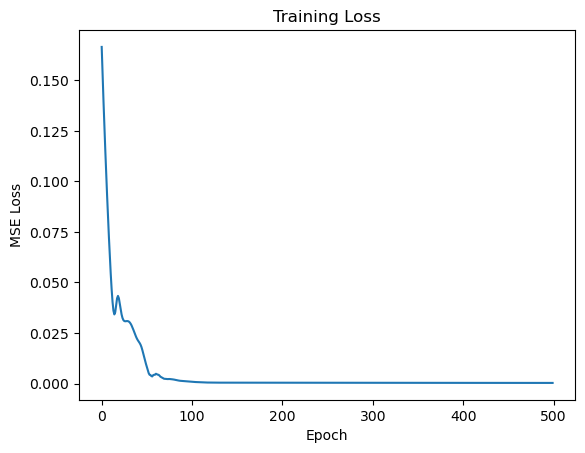

In [167]:
num_epochs=500
losses=[]
for epoch in range(num_epochs):
    model.train()
    outputs=model(X_train)
    loss=loss_func(outputs,y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

Test MSE: 91.798409


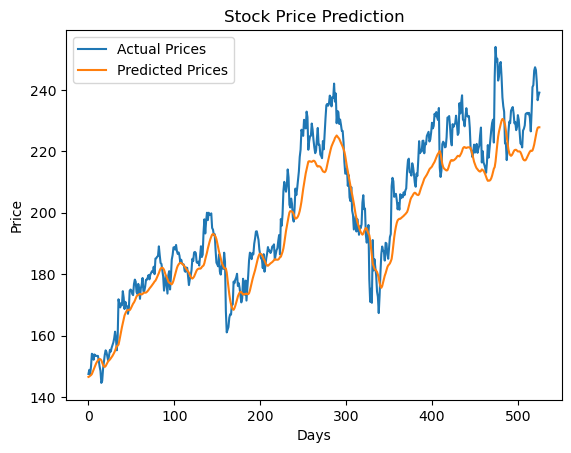

In [168]:
#testing loop


model.eval()
with torch.no_grad():
    predictions=model(X_test).numpy()
    predictions=scaler.inverse_transform(predictions)
    actual=scaler.inverse_transform(y_test.numpy())
    mse=loss_func(torch.from_numpy(predictions),torch.from_numpy(actual))
    print(f'Test MSE: {mse.item():.6f}')
    plt.plot(actual,label='Actual Prices')
    plt.plot(predictions,label='Predicted Prices')
    plt.title('Stock Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()




In [169]:
import yfinance as yf
recent_data = yf.download('AMZN', start='2024-12-15', end='2026-01-20')['Close']
recent_closes = recent_data.dropna().tail(30).values.reshape(1, -1, 1)

recent_closes.shape

[*********************100%***********************]  1 of 1 completed


(1, 30, 1)

In [170]:
recent_scaled = scaler.transform(recent_closes.reshape(-1,1)).reshape(1,30,1)
recent_tensor = torch.from_numpy(recent_scaled).float()

with torch.no_grad():
    recent_pred=model(recent_tensor).numpy()
    recent_pred_price=scaler.inverse_transform(recent_pred)
    print(f'Predicted closing price for 19th jan 2026: {recent_pred_price[0][0]:.2f}')

Predicted closing price for 19th jan 2026: 227.76


In [171]:
torch.save(model.state_dict(), 'best_stocklstm.pth')